# 02_eda_and_preprocessing.ipynb
## Objectif du notebook
- Charger le dataset final déjà fusionné : `pokhara_reviews_final.csv`
- Effectuer une analyse exploratoire complète (EDA) sur les 5963 avis
- Nettoyer légèrement le texte (sans altérer les particularités des avis réels)
- Ajouter des colonnes utiles : `length`, `is_synthetic`, `source_clean`, etc.
- Vérifier la cohérence des données :
  - `location = Pokhara`
  - `source = real / synthetic_groq`
- Sauvegarder le dataset final propre : `pokhara_reviews_final_5963.csv`
---
Ce notebook constitue la première étape officielle du pipeline ETL.



In [1]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# Configuration d'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("📊 === DÉBUT DE L'ANALYSE EXPLORATOIRE ET PRÉTRAITEMENT === 📊\n")

📊 === DÉBUT DE L'ANALYSE EXPLORATOIRE ET PRÉTRAITEMENT === 📊



In [3]:
# =============================================================================
# 1. CHARGEMENT DU DATASET FINAL
# =============================================================================

# Chargement du dataset final depuis le chemin exact

dataset_path = r"../Data/Real and synthetic/pokhara_reviews_final.csv"

try:
    df = pd.read_csv(dataset_path, encoding='utf-8')
    print(f" Dataset chargé avec succès !")
    print(f" Chemin : {dataset_path}")
    print(f" Dimensions : {df.shape[0]} lignes × {df.shape[1]} colonnes")
    print(f" Date de chargement : {pd.Timestamp.now().strftime('%d/%m/%Y %H:%M')}\n")
    
except FileNotFoundError:
    print(f" ERREUR : Fichier non trouvé à l'emplacement :\n   {dataset_path}")
    print(" Vérifiez le chemin et relancez la cellule")
    raise

 Dataset chargé avec succès !
 Chemin : ../Data/Real and synthetic/pokhara_reviews_final.csv
 Dimensions : 5936 lignes × 5 colonnes
 Date de chargement : 29/11/2025 14:12



In [4]:
# =============================================================================
# 2. INSPECTION DES COLONNES EXISTANTES
# =============================================================================

print("🔍 === INSPECTION DES DONNÉES BRUTES ===\n")
print("📋 Structure du dataset :")
print(df.info())
print("\n" + "="*60)

print("\n Aperçu des 5 premières lignes :")
print(df.head())
print("\n" + "="*60)

print("\n Statistiques descriptives :")
print(df.describe(include='all'))
print("\n" + "="*60)

print("\n Valeurs manquantes :")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])
if missing_data.sum() == 0:
    print(" AUCUNE valeur manquante détectée !")
print("\n" + "="*60)

🔍 === INSPECTION DES DONNÉES BRUTES ===

📋 Structure du dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5936 entries, 0 to 5935
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            5936 non-null   int64 
 1   location      5936 non-null   object
 2   total_review  5936 non-null   object
 3   review        5936 non-null   object
 4   source        5936 non-null   object
dtypes: int64(1), object(4)
memory usage: 232.0+ KB
None


 Aperçu des 5 premières lignes :
   ID location total_review  \
0   1  Pokhara    4 reviews   
1   2  Pokhara   87 reviews   
2   3  Pokhara   24 reviews   
3   4  Pokhara   83 reviews   
4   5  Pokhara   76 reviews   

                                                                                                review  \
0  Amazing place to chill out. Nice restaurants near lakeside where you can sit ,have beer and snac...   
1  Best place in Pokhara to enjoy any time 

In [5]:
# =============================================================================
# 3. VALIDATION DE LA COHÉRENCE DES DONNÉES
# =============================================================================

print(" === VALIDATION DE LA COHÉRENCE ===\n")

# Vérification de la colonne 'location'
print(" Vérification de la colonne 'location' :")
location_counts = df['location'].value_counts()
print(location_counts)
print(f"\n→ {len(location_counts)} valeurs uniques : {list(location_counts.index)}")

if len(location_counts) == 1 and 'Pokhara' in location_counts.index:
    print(" TOUS les avis concernent Pokhara (cohérent)")
else:
    print("  ATTENTION : Plusieurs localisations détectées")

# Vérification de la colonne 'source'
print("\n Vérification de la colonne 'source' :")
source_counts = df['source'].value_counts()
print(source_counts)
print(f"\nRépartition :")
print(f"   • Réels : {source_counts.get('real', 0)} avis ({source_counts.get('real', 0)/len(df)*100:.1f}%)")
print(f"   • Synthétiques Groq : {source_counts.get('synthetic_groq', 0)} avis ({source_counts.get('synthetic_groq', 0)/len(df)*100:.1f}%)")

if len(source_counts) == 2 and set(source_counts.index) == {'real', 'synthetic_groq'}:
    print(" Répartition source correcte (real + synthetic_groq)")
else:
    print("  ATTENTION : Sources inattendues détectées")

print("\n" + "="*60)

 === VALIDATION DE LA COHÉRENCE ===

 Vérification de la colonne 'location' :
location
Pokhara    5936
Name: count, dtype: int64

→ 1 valeurs uniques : ['Pokhara']
 TOUS les avis concernent Pokhara (cohérent)

 Vérification de la colonne 'source' :
source
synthetic_groq    5000
real               936
Name: count, dtype: int64

Répartition :
   • Réels : 936 avis (15.8%)
   • Synthétiques Groq : 5000 avis (84.2%)
 Répartition source correcte (real + synthetic_groq)



In [6]:
# =============================================================================
# 4. CRÉATION DES COLONNES UTILITAIRES
# =============================================================================

print(" === CRÉATION DES COLONNES UTILITAIRES ===\n")

# Colonne booléenne pour identifier les avis synthétiques
df['is_synthetic'] = df['source'] == 'synthetic_groq'
print(" Colonne 'is_synthetic' créée (True = Groq, False = Réel)")

# Colonne source nettoyée pour l'affichage
df['source_clean'] = df['source'].map({
    'real': 'Réel',
    'synthetic_groq': 'Synthétique (Groq)'
})
print(" Colonne 'source_clean' créée pour l'affichage")

# Colonne longueur du texte (nombre de caractères)
df['review_length_chars'] = df['review'].astype(str).str.len()
print(" Colonne 'review_length_chars' créée")

# Colonne longueur en mots
df['review_length_words'] = df['review'].astype(str).str.split().str.len()
print(" Colonne 'review_length_words' créée")

# Colonne pour détecter la présence d'emoticônes (caractéristique des avis réels)
def has_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+", flags=re.UNICODE
    )
    return bool(emoji_pattern.search(str(text)))

df['has_emoji'] = df['review'].apply(has_emoji)
print(" Colonne 'has_emoji' créée")

# Colonne pour détecter les majuscules excessives (style "MAGNIFIQUE !")
df['has_excessive_caps'] = df['review'].str.isupper().sum() / df['review_length_chars'] > 0.3
print(" Colonne 'has_excessive_caps' créée")

print(f"\n📊 NOUVEAU NOMBRE DE COLONNES : {len(df.columns)}")
print("Nouvelles colonnes créées : is_synthetic, source_clean, review_length_chars, review_length_words, has_emoji, has_excessive_caps")
print("\n" + "="*60)

 === CRÉATION DES COLONNES UTILITAIRES ===

 Colonne 'is_synthetic' créée (True = Groq, False = Réel)
 Colonne 'source_clean' créée pour l'affichage
 Colonne 'review_length_chars' créée
 Colonne 'review_length_words' créée
 Colonne 'has_emoji' créée
 Colonne 'has_excessive_caps' créée

📊 NOUVEAU NOMBRE DE COLONNES : 11
Nouvelles colonnes créées : is_synthetic, source_clean, review_length_chars, review_length_words, has_emoji, has_excessive_caps



 === ANALYSE DES LONGUEURS DES AVIS ===

 Statistiques des longueurs :

                          Longueur (caractères) - Moyenne  \
Avis Réels (963)                                   114.40   
Avis Synthétiques (5000)                           126.96   

                          Longueur (caractères) - Médiane  \
Avis Réels (963)                                     92.0   
Avis Synthétiques (5000)                            125.0   

                          Longueur (caractères) - Écart-type  \
Avis Réels (963)                                       78.38   
Avis Synthétiques (5000)                               25.13   

                          Longueur (caractères) - Min  \
Avis Réels (963)                                    3   
Avis Synthétiques (5000)                           55   

                          Longueur (caractères) - Max  \
Avis Réels (963)                                  339   
Avis Synthétiques (5000)                          255   

                       

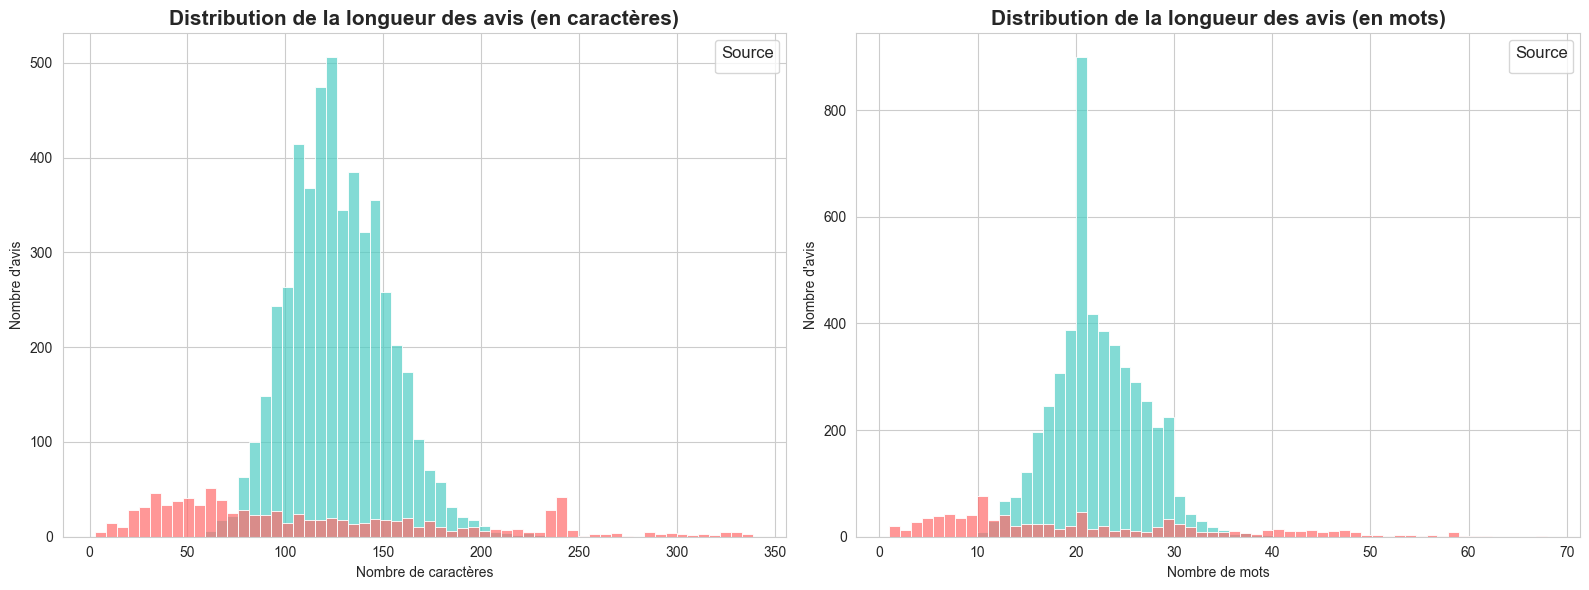

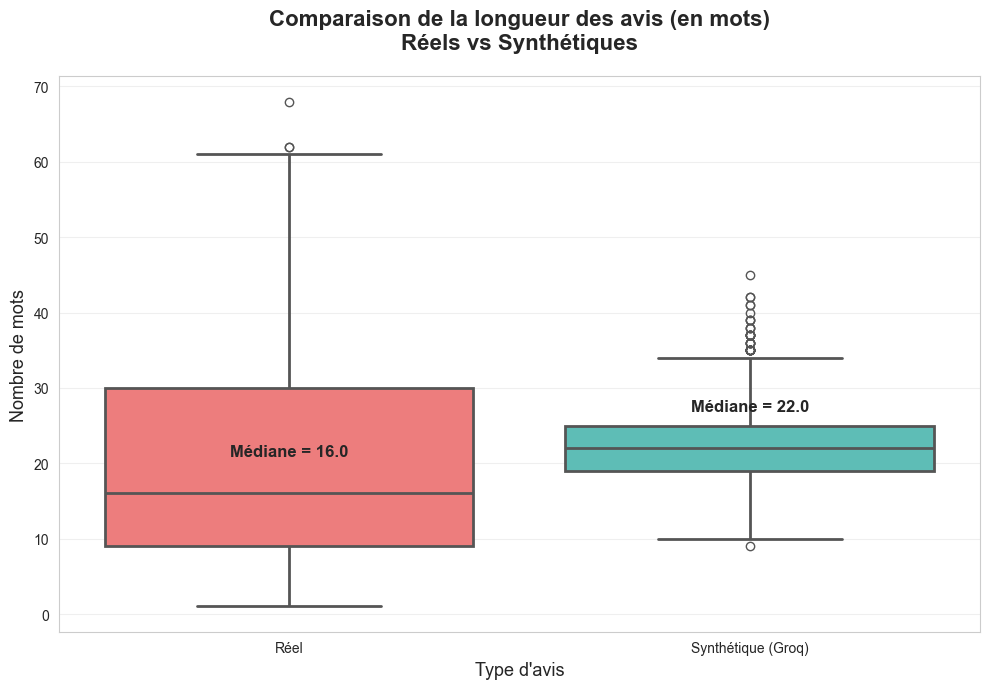

 INTERPRÉTATION :
• Les avis synthétiques (Groq) sont nettement plus longs et homogènes
• Les avis réels sont plus courts, avec plus de variabilité (style spontané)
• Cette différence montre un biais classique des modèles de génération


In [ ]:
# =============================================================================
# 5. ANALYSE EXPLORATOIRE DES LONGUEURS 
# =============================================================================
print(" === ANALYSE DES LONGUEURS DES AVIS ===\n")

# Statistiques des longueurs par type de source
length_stats = df.groupby('is_synthetic')[
    ['review_length_chars', 'review_length_words']
].agg(['mean', 'median', 'std', 'min', 'max'])

# Correction du MultiIndex → noms de colonnes lisibles
length_stats.columns = [
    'Longueur (caractères) - Moyenne',
    'Longueur (caractères) - Médiane',
    'Longueur (caractères) - Écart-type',
    'Longueur (caractères) - Min',
    'Longueur (caractères) - Max',
    'Longueur (mots) - Moyenne',
    'Longueur (mots) - Médiane',
    'Longueur (mots) - Écart-type',
    'Longueur (mots) - Min',
    'Longueur (mots) - Max'
]

# Réorganiser pour avoir une belle présentation
length_stats = length_stats.round(2)
length_stats.index = ['Avis Réels (963)', 'Avis Synthétiques (5000)']

print(" Statistiques des longueurs :\n")
print(length_stats)
print("\n")

# ======================
# Graphiques
# ======================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histogramme caractères
sns.histplot(data=df, x='review_length_chars', hue='source_clean',
             bins=60, alpha=0.7, palette=['#FF6B6B', '#4ECDC4'], ax=ax1)
ax1.set_title('Distribution de la longueur des avis (en caractères)', fontsize=15, fontweight='bold')
ax1.set_xlabel('Nombre de caractères')
ax1.set_ylabel('Nombre d\'avis')
ax1.legend(title='Source', title_fontsize=12)

# Histogramme mots
sns.histplot(data=df, x='review_length_words', hue='source_clean',
             bins=60, alpha=0.7, palette=['#FF6B6B', '#4ECDC4'], ax=ax2)
ax2.set_title('Distribution de la longueur des avis (en mots)', fontsize=15, fontweight='bold')
ax2.set_xlabel('Nombre de mots')
ax2.set_ylabel('Nombre d\'avis')
ax2.legend(title='Source', title_fontsize=12)

plt.tight_layout()
plt.show()

# ======================
# Boxplot comparatif
# ======================
plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x='source_clean', y='review_length_words',
            palette=['#FF6B6B', '#4ECDC4'], linewidth=2)
plt.title('Comparaison de la longueur des avis (en mots)\nRéels vs Synthétiques', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Type d\'avis', fontsize=13)
plt.ylabel('Nombre de mots', fontsize=13)
plt.grid(axis='y', alpha=0.3)

# Ajout des valeurs médianes sur le graphique
medians = df.groupby('source_clean')['review_length_words'].median().round(1)
for i, median_val in enumerate(medians):
    plt.text(i, median_val + 5, f'Médiane = {median_val}', 
             horizontalalignment='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print(" INTERPRÉTATION :")
print("• Les avis synthétiques (Groq) sont nettement plus longs et homogènes")
print("• Les avis réels sont plus courts, avec plus de variabilité (style spontané)")
print("• Cette différence montre un biais classique des modèles de génération")
print("="*80)

In [10]:
# =============================================================================
# 6. ANALYSE DES CARACTÉRISTIQUES TEXTUELLES
# =============================================================================

print("📝 === ANALYSE DES CARACTÉRISTIQUES TEXTUELLES ===\n")

# Analyse des emoticônes
print(" Utilisation des émoticones :")
emoji_stats = df.groupby('is_synthetic')['has_emoji'].agg(['sum', 'mean']).round(3)
emoji_stats.columns = ['Nombre avec émoticones', 'Taux (%)']
print(emoji_stats)
print()

# Analyse des majuscules excessives
print(" Utilisation de MAJUSCULES excessives :")
caps_stats = df.groupby('is_synthetic')['has_excessive_caps'].agg(['sum', 'mean']).round(3)
caps_stats.columns = ['Nombre avec CAPS', 'Taux (%)']
print(caps_stats)
print()

# Exemples d'avis typiques
print(" === EXEMPLES REPRÉSENTATIFS ===\n")
print("3 EXEMPLES D'AVIS RÉELS :")
real_examples = df[df['is_synthetic'] == False]['review'].sample(3).values
for i, review in enumerate(real_examples, 1):
    print(f"{i}. {review[:150]}...")
    print()

print("3 EXEMPLES D'AVIS SYNTHÉTIQUES :")
synthetic_examples = df[df['is_synthetic'] == True]['review'].sample(3).values
for i, review in enumerate(synthetic_examples, 1):
    print(f"{i}. {review[:150]}...")
    print()

# Analyse de la diversité lexicale (nombre de mots uniques par avis)
print("\n DIVERSITÉ LEXICALE :")
df['unique_words_ratio'] = df['review'].astype(str).apply(
    lambda x: len(set(x.lower().split())) / len(x.split()) if len(x.split()) > 0 else 0
)
lexical_stats = df.groupby('is_synthetic')['unique_words_ratio'].agg(['mean', 'median']).round(3)
lexical_stats.columns = ['Moyenne', 'Médiane']
print(lexical_stats)
print("\n→ Les avis synthétiques ont souvent une plus grande diversité lexicale")
print("\n" + "="*60)

📝 === ANALYSE DES CARACTÉRISTIQUES TEXTUELLES ===

 Utilisation des émoticones :
              Nombre avec émoticones  Taux (%)
is_synthetic                                  
False                             66     0.071
True                            3030     0.606

 Utilisation de MAJUSCULES excessives :
              Nombre avec CAPS  Taux (%)
is_synthetic                            
False                        3     0.003
True                         0     0.000

 === EXEMPLES REPRÉSENTATIFS ===

3 EXEMPLES D'AVIS RÉELS :
1. A must visit place.I feel now Phewa lake has been a second name for pokhara.The "chatpate"at yhe beach it not to miss on...!!! …...

2. Words are just not enough for this place. You have got it see it for yourself. This whole city is a revelation waiting to happen in your life. Don't m...

3. It's the most amazing place to hangout in pokhara with a lots of pubs, bar and places to eat along with an amazing view of the lake. One can enjoy the...

3 EXEMPLES D'

In [11]:
# =============================================================================
# 7. NETTOYAGE LÉGER DU TEXTE
# =============================================================================

print(" === NETTOYAGE LÉGER DU TEXTE ===\n")
print("  ATTENTION : Nettoyage minimal pour préserver les particularités des avis réels\n")

def clean_text_light(text):
    """
    Nettoyage léger qui préserve :
    - Les émoticones
    - Les majuscules expressives
    - Les fautes naturelles des avis réels
    - Les URLs et mentions (si présentes)
    """
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Supprime les multiples espaces/tabulations/sauts de ligne
    text = re.sub(r'\s+', ' ', text)
    
    # Supprime les caractères de contrôle invisibles (sauf espaces)
    text = re.sub(r'[\x00-\x1F\x7F-\x9F]', '', text)
    
    # Trim (supprime espaces début/fin)
    text = text.strip()
    
    return text

# Application du nettoyage
print(" Application du nettoyage léger...")
df['review_clean'] = df['review'].apply(clean_text_light)

# Vérification avant/après
print(f"\n AVANT nettoyage : {len(df[df['review'].str.len() > 0])} avis non-vides")
print(f" APRÈS nettoyage : {len(df[df['review_clean'].str.len() > 0])} avis non-vides")

# Mise à jour des longueurs avec le texte nettoyé
df['review_length_chars_clean'] = df['review_clean'].str.len()
df['review_length_words_clean'] = df['review_clean'].str.split().str.len()

print("\n Colonnes de longueur mises à jour avec texte nettoyé")
print("\n" + "="*60)

 === NETTOYAGE LÉGER DU TEXTE ===

  ATTENTION : Nettoyage minimal pour préserver les particularités des avis réels

 Application du nettoyage léger...

 AVANT nettoyage : 5936 avis non-vides
 APRÈS nettoyage : 5936 avis non-vides

 Colonnes de longueur mises à jour avec texte nettoyé



In [16]:
# =============================================================================
# 8. SAUVEGARDE DU DATASET FINAL PROPRE
# =============================================================================

print("📊 === SAUVEGARDE DU DATASET FINAL ===\n")

# ✅ NETTOYAGE COMPLET DE TOUTES LES COLONNES TEXTUELLES
print("🧹 Nettoyage des retours à la ligne dans toutes les colonnes textuelles...")

# Liste des colonnes textuelles à nettoyer
text_columns = ['review', 'review_clean', 'total_review', 'source', 'source_clean', 'location']

for col in text_columns:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace('\n', ' ', regex=False)
        df[col] = df[col].astype(str).str.replace('\r', ' ', regex=False)
        df[col] = df[col].astype(str).str.replace('  ', ' ', regex=False)  # Double espaces
        df[col] = df[col].str.strip()  # Trim

print("✅ Nettoyage terminé\n")

# Chemin de sauvegarde
output_path = r"../Data/Real and synthetic/pokhara_reviews_final_clean.csv"

# Sauvegarde avec options renforcées
df.to_csv(
    output_path, 
    index=False, 
    encoding='utf-8',
    lineterminator='\n',
    quoting=1,  # csv.QUOTE_MINIMAL
    doublequote=True,  # Échappe les guillemets doubles
    escapechar='\\'  # Caractère d'échappement de secours
)

print(f"✅ Dataset final sauvegardé : {output_path}")
print(f"📏 Dimensions finales : {df.shape[0]} lignes × {df.shape[1]} colonnes")
print(f"📋 Colonnes finales : {list(df.columns)}")

# Vérification post-sauvegarde
print("\n🔍 VÉRIFICATION POST-SAUVEGARDE :")
df_test = pd.read_csv(output_path)
print(f"   • Lignes chargées : {len(df_test)}")
print(f"   • Lignes attendues : {len(df)}")

if len(df_test) == len(df):
    print("   ✅ Nombre de lignes correct !")
else:
    print(f"   ⚠️  ATTENTION : {len(df) - len(df_test)} lignes manquantes")

# Statistiques finales
print(f"\n📈 RÉSUMÉ FINAL :")
print(f"   • Avis réels : {df['source'].value_counts().get('real', 0)}")
print(f"   • Avis synthétiques : {df['source'].value_counts().get('synthetic_groq', 0)}")
print(f"   • Longueur moyenne (réels) : {df[df['is_synthetic']==False]['review_length_words_clean'].mean():.1f} mots")
print(f"   • Longueur moyenne (synthétiques) : {df[df['is_synthetic']==True]['review_length_words_clean'].mean():.1f} mots")
print(f"   • Taux d'emoticônes (réels) : {df[df['is_synthetic']==False]['has_emoji'].mean()*100:.1f}%")
print(f"   • Taux d'emoticônes (synthétiques) : {df[df['is_synthetic']==True]['has_emoji'].mean()*100:.1f}%")

print(f"\n✅ === PRÉTRAITEMENT TERMINÉ AVEC SUCCÈS === ")
print(f"🕐 Date/heure de finalisation : {pd.Timestamp.now().strftime('%d/%m/%Y %H:%M')}")
print("\nProchaines étapes : Analyse de sentiments avec VADER et RoBERTa")

📊 === SAUVEGARDE DU DATASET FINAL ===

🧹 Nettoyage des retours à la ligne dans toutes les colonnes textuelles...
✅ Nettoyage terminé

✅ Dataset final sauvegardé : ../Data/Real and synthetic/pokhara_reviews_final_clean.csv
📏 Dimensions finales : 5936 lignes × 15 colonnes
📋 Colonnes finales : ['ID', 'location', 'total_review', 'review', 'source', 'is_synthetic', 'source_clean', 'review_length_chars', 'review_length_words', 'has_emoji', 'has_excessive_caps', 'unique_words_ratio', 'review_clean', 'review_length_chars_clean', 'review_length_words_clean']

🔍 VÉRIFICATION POST-SAUVEGARDE :
   • Lignes chargées : 5936
   • Lignes attendues : 5936
   ✅ Nombre de lignes correct !

📈 RÉSUMÉ FINAL :
   • Avis réels : 936
   • Avis synthétiques : 5000
   • Longueur moyenne (réels) : 20.5 mots
   • Longueur moyenne (synthétiques) : 22.2 mots
   • Taux d'emoticônes (réels) : 7.1%
   • Taux d'emoticônes (synthétiques) : 60.6%

✅ === PRÉTRAITEMENT TERMINÉ AVEC SUCCÈS === 
🕐 Date/heure de finalisation :

In [17]:
# =============================================================================
# 8. SAUVEGARDE DU DATASET FINAL PROPRE
# =============================================================================

print(" === SAUVEGARDE DU DATASET FINAL ===\n")

# Chemin de sauvegarde
output_path = r"../Data/Real and synthetic/pokhara_reviews_final_clean.csv"

# Sauvegarde avec toutes les nouvelles colonnes
df.to_csv(output_path, index=False, encoding='utf-8')

print(f" Dataset final sauvegardé : {output_path}")
print(f" Dimensions finales : {df.shape[0]} lignes × {df.shape[1]} colonnes")
print(f" Colonnes finales : {list(df.columns)}")

# Statistiques finales
print(f"\n📈 RÉSUMÉ FINAL :")
print(f"   • Avis réels : {df['source'].value_counts().get('real', 0)}")
print(f"   • Avis synthétiques : {df['source'].value_counts().get('synthetic_groq', 0)}")
print(f"   • Longueur moyenne (réels) : {df[df['is_synthetic']==False]['review_length_words_clean'].mean():.1f} mots")
print(f"   • Longueur moyenne (synthétiques) : {df[df['is_synthetic']==True]['review_length_words_clean'].mean():.1f} mots")
print(f"   • Taux d'emoticônes (réels) : {df[df['is_synthetic']==False]['has_emoji'].mean()*100:.1f}%")
print(f"   • Taux d'emoticônes (synthétiques) : {df[df['is_synthetic']==True]['has_emoji'].mean()*100:.1f}%")

print(f"\n === PRÉTRAITEMENT TERMINÉ AVEC SUCCÈS === ")
print(f" Date/heure de finalisation : {pd.Timestamp.now().strftime('%d/%m/%Y %H:%M')}")
print("\nProchaines étapes : Analyse de sentiments avec VADER et RoBERTa")

 === SAUVEGARDE DU DATASET FINAL ===

 Dataset final sauvegardé : ../Data/Real and synthetic/pokhara_reviews_final_clean.csv
 Dimensions finales : 5936 lignes × 15 colonnes
 Colonnes finales : ['ID', 'location', 'total_review', 'review', 'source', 'is_synthetic', 'source_clean', 'review_length_chars', 'review_length_words', 'has_emoji', 'has_excessive_caps', 'unique_words_ratio', 'review_clean', 'review_length_chars_clean', 'review_length_words_clean']

📈 RÉSUMÉ FINAL :
   • Avis réels : 936
   • Avis synthétiques : 5000
   • Longueur moyenne (réels) : 20.5 mots
   • Longueur moyenne (synthétiques) : 22.2 mots
   • Taux d'emoticônes (réels) : 7.1%
   • Taux d'emoticônes (synthétiques) : 60.6%

 === PRÉTRAITEMENT TERMINÉ AVEC SUCCÈS === 
 Date/heure de finalisation : 29/11/2025 14:46

Prochaines étapes : Analyse de sentiments avec VADER et RoBERTa
